Question 1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Saving spam.csv to spam (2).csv


<Axes: xlabel='v1'>

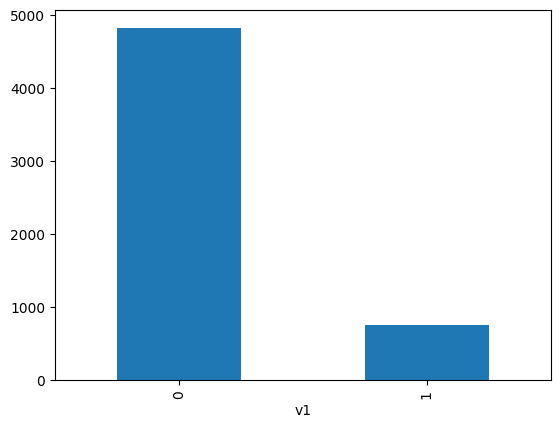

In [11]:
from google.colab import files
import pandas
import nltk
from nltk.corpus import stopwords
from numpy import vectorize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re

nltk.download('stopwords')

uploaded = files.upload()

def classify(val):
    if val=='ham':
        return 0
    else:
        return 1

df = pandas.read_csv('spam.csv', encoding='latin-1')

df['v1'] = df['v1'].apply(classify)
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['clean_message'] = df['v2'].apply(clean_text)
df.drop(['v2'], axis=1, inplace=True)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_message'])

y = df['v1']   # FIXED

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# class distribution
df['v1'].value_counts()
df['v1'].value_counts(normalize=True) * 100
df['v1'].value_counts().plot(kind='bar')




In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

cm = confusion_matrix(y_test, test_pred)
print("Confusion Matrix:")
print(cm)


Train Accuracy: 0.8851245232218982
Test Accuracy: 0.8923766816143498
Confusion Matrix:
[[925  40]
 [ 80  70]]


Iteration: 1
Misclassified: [   1    6   17   33   34   51   58   71   73   80   96  101  103  107
  108  120  122  132  147  148  154  187  190  200  208  212  214  216
  222  245  249  259  271  278  292  300  303  304  311  316  334  337
  342  370  388  391  392  407  412  421  457  468  469  485  486  489
  492  502  512  519  522  531  534  544  551  557  560  588  603  610
  611  623  626  627  629  630  631  642  643  646  652  659  664  672
  673  681  703  712  714  715  723  729  775  776  780  805  809  822
  847  863  871  881  886  887  893  910  925  946  965  968  978  995
  997 1002 1014 1019 1073 1082 1084 1091 1092 1144 1170 1187 1204 1208
 1228 1232 1236 1237 1239 1245 1246 1250 1267 1285 1299 1303 1306 1313
 1314 1315 1322 1328 1330 1343 1354 1356 1361 1369 1386 1407 1414 1419
 1422 1435 1440 1449 1450 1456 1457 1460 1467 1470 1471 1480 1486 1489
 1496 1505 1510 1527 1530 1534 1540 1546 1559 1573 1574 1588 1592 1596
 1598 1609 1612 1622 1634 1642 1645 1650 1652 165

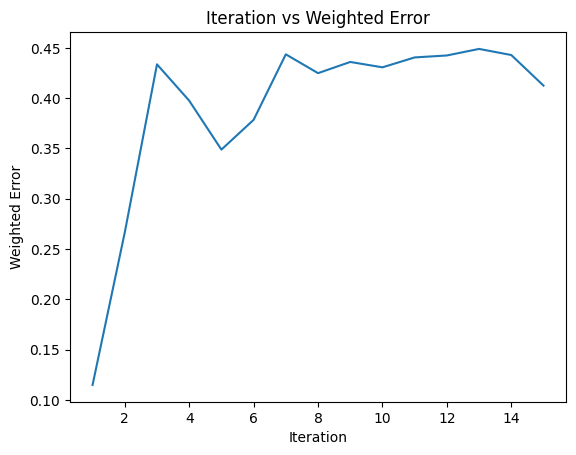

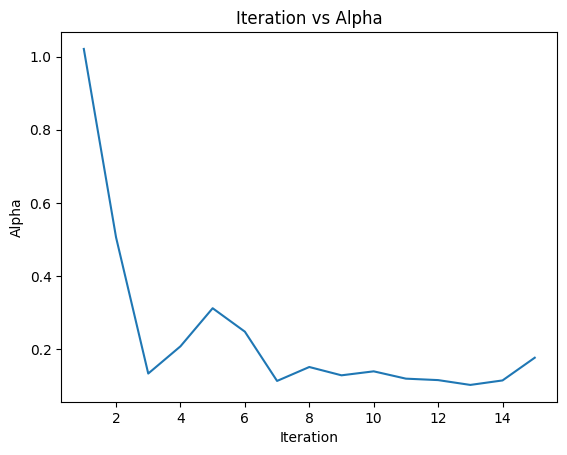

In [15]:
import numpy as np
import pandas
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

X_train_arr = X_train.toarray()
X_test_arr = X_test.toarray()

y_train_arr = y_train.values
y_test_arr = y_test.values

y_train_arr = np.where(y_train_arr == 0, -1, 1)
y_test_arr = np.where(y_test_arr == 0, -1, 1)

n = X_train_arr.shape[0]
w = np.ones(n) / n

T = 15
alphas = []
errors = []

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train_arr, y_train_arr, sample_weight=w)

    pred = stump.predict(X_train_arr)
    misclassified = np.where(pred != y_train_arr)[0]

    err = np.sum(w[misclassified])
    errors.append(err)

    alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
    alphas.append(alpha)

    print("Iteration:", t+1)
    print("Misclassified:", misclassified)
    print("Weights:", w[misclassified])
    print("Alpha:", alpha)
    print()

    w = w * np.exp(-alpha * y_train_arr * pred)
    w = w / np.sum(w)

models = []
for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X_train_arr, y_train_arr, sample_weight=None)
    models.append(stump)

final_train = np.zeros(len(X_train_arr))
final_test = np.zeros(len(X_test_arr))

for alpha, m in zip(alphas, models):
    final_train += alpha * m.predict(X_train_arr)
    final_test += alpha * m.predict(X_test_arr)

final_train_pred = np.where(final_train >= 0, 1, -1)
final_test_pred = np.where(final_test >= 0, 1, -1)

train_acc = accuracy_score(y_train_arr, final_train_pred)
test_acc = accuracy_score(y_test_arr, final_test_pred)
cm = confusion_matrix(y_test_arr, final_test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Confusion Matrix:")
print(cm)

plt.plot(range(1, T+1), errors)
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.title("Iteration vs Weighted Error")
plt.show()

plt.plot(range(1, T+1), alphas)
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.title("Iteration vs Alpha")
plt.show()


In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1)

ada = AdaBoostClassifier(
    estimator=stump,
    n_estimators=100,
    learning_rate=0.6
)

ada.fit(X_train, y_train)

train_pred = ada.predict(X_train)
test_pred = ada.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
print("Confusion Matrix:")
print(cm)



Train Accuracy: 0.9178819833969037
Test Accuracy: 0.9237668161434978
Confusion Matrix:
[[963   2]
 [ 83  67]]


Question 2.

Baseline Train Accuracy: 0.7396694214876033
Baseline Test Accuracy: 0.8360655737704918
[[26  3]
 [ 7 25]]
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



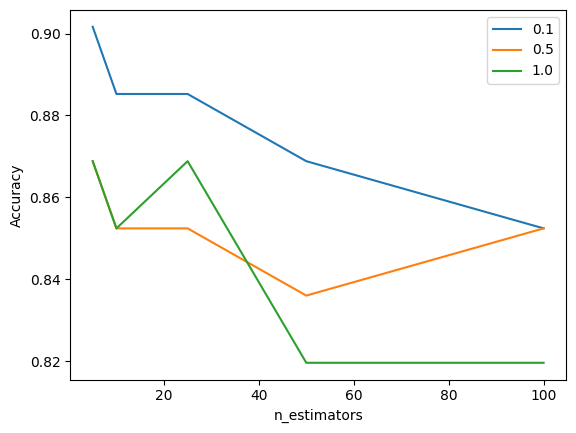

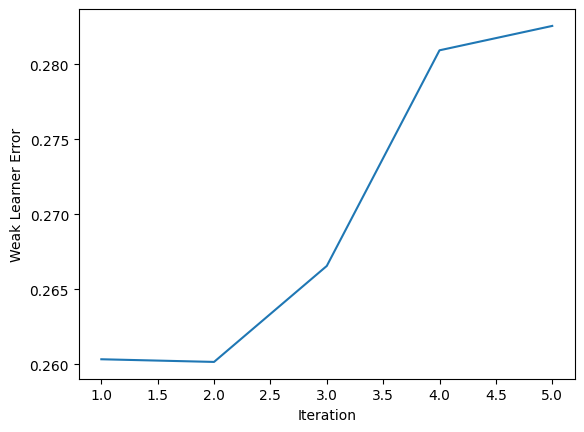

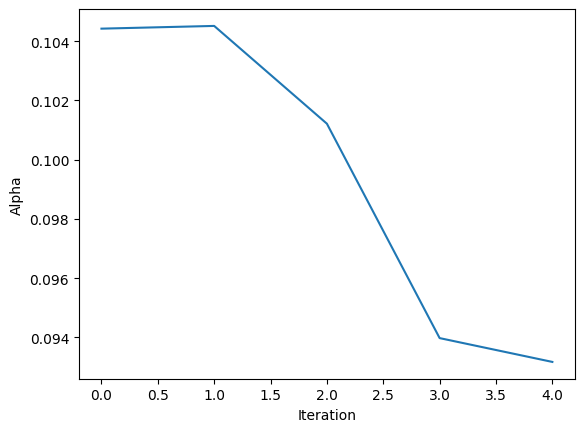

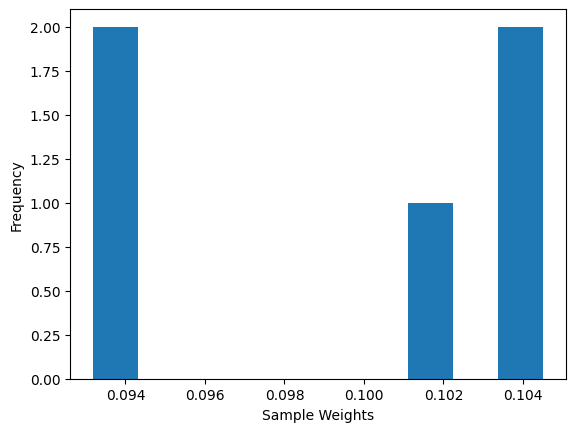

      feature  importance
11    num__ca    0.399137
2     num__cp    0.397335
12  num__thal    0.203528
0    num__age    0.000000
1    num__sex    0.000000


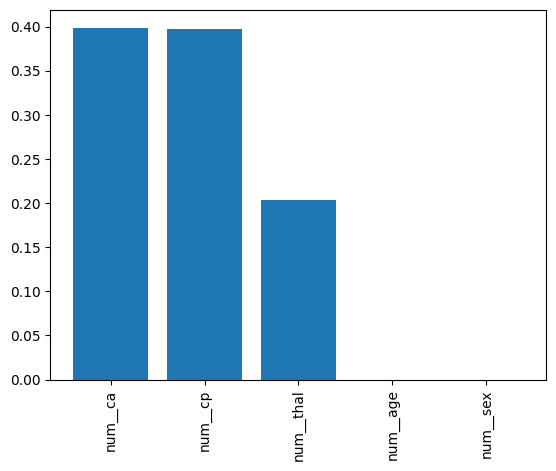

In [24]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = fetch_openml("heart-disease", version=1, as_frame=True)
df = data.frame

X = df.drop("target", axis=1)
y = df["target"].astype(int)

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

stump = DecisionTreeClassifier(max_depth=1)

baseline_model = Pipeline([
    ('prep', preprocessor),
    ('clf', stump)
])

baseline_model.fit(X_train, y_train)

train_pred = baseline_model.predict(X_train)
test_pred = baseline_model.predict(X_test)

print("Baseline Train Accuracy:", accuracy_score(y_train, train_pred))
print("Baseline Test Accuracy:", accuracy_score(y_test, test_pred))
print(confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred))

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]
results = {}

for lr in learning_rates:
    acc_list = []
    for n in n_estimators_list:
        model = Pipeline([
            ('prep', preprocessor),
            ('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n, learning_rate=lr))
        ])
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        acc_list.append(accuracy_score(y_test, pred))
    results[lr] = acc_list

for lr in learning_rates:
    plt.plot(n_estimators_list, results[lr], label=str(lr))

plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

best_lr = None
best_n = None
best_acc = -1

for lr in learning_rates:
    for i, n in enumerate(n_estimators_list):
        if results[lr][i] > best_acc:
            best_acc = results[lr][i]
            best_lr = lr
            best_n = n

best_model = Pipeline([
    ('prep', preprocessor),
    ('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=best_n, learning_rate=best_lr))
])

best_model.fit(X_train, y_train)

ada = best_model.named_steps['ada']
errors = ada.estimator_errors_

plt.plot(range(1, len(errors) + 1), errors)
plt.xlabel("Iteration")
plt.ylabel("Weak Learner Error")
plt.show()

alphas = ada.estimator_weights_
plt.plot(alphas)
plt.xlabel("Iteration")
plt.ylabel("Alpha")
plt.show()

plt.hist(alphas)
plt.xlabel("Sample Weights")
plt.ylabel("Frequency")
plt.show()

feature_importances = ada.feature_importances_
feature_names = best_model.named_steps['prep'].get_feature_names_out()

imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

print(imp_df.head(5))

plt.bar(imp_df['feature'].head(5), imp_df['importance'].head(5))
plt.xticks(rotation=90)
plt.show()


Question 3

In [27]:
from google.colab import files
uploaded = files.upload()


Saving WISDM_ar_v1.1_raw.txt to WISDM_ar_v1.1_raw.txt


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

path = "/content/WISDM_ar_v1.1_raw.txt"
raw = []
with open(path) as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) >= 6:
            try:
                user = parts[0].split()[0]
                activity = parts[1]
                x = float(parts[3])
                y = float(parts[4])
                z = float(parts[5])
                raw.append([activity, x, y, z])
            except:
                pass

df = pd.DataFrame(raw, columns=["activity","x","y","z"])
vigorous = ["Jogging","Upstairs"]
df["label"] = df["activity"].apply(lambda a: 1 if a in vigorous else 0)
df = df.dropna()

X = df[["x","y","z"]].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)
train_pred_stump = stump.predict(X_train)
test_pred_stump = stump.predict(X_test)

print("Stump Train Acc:", accuracy_score(y_train, train_pred_stump))
print("Stump Test Acc:", accuracy_score(y_test, test_pred_stump))
print("Stump Confusion:\n", confusion_matrix(y_test, test_pred_stump))

T = 20
w = np.ones(len(X_train)) / len(X_train)
alphas = []
errors = []

models = []
for t in range(T):
    stump_t = DecisionTreeClassifier(max_depth=1)
    stump_t.fit(X_train, y_train, sample_weight=w)
    pred = stump_t.predict(X_train)

    mis = (pred != y_train)
    err = np.sum(w[mis])
    alpha = 0.5 * np.log((1 - err) / err)

    idx = np.where(mis)[0]
    print("Iter:", t+1)
    print("Mis:", idx)
    print("Mis Weights:", w[idx])

    w = w * np.exp(-alpha * y_train * (2*pred - 1))
    w = w / np.sum(w)

    models.append(stump_t)
    alphas.append(alpha)
    errors.append(err)

def predict_manual(X):
    s = np.zeros(X.shape[0])
    for model, alpha in zip(models, alphas):
        s += alpha * (2*model.predict(X) - 1)
    return (s > 0).astype(int)

train_manual = predict_manual(X_train)
test_manual = predict_manual(X_test)

print("Manual AdaBoost Train Acc:", accuracy_score(y_train, train_manual))
print("Manual AdaBoost Test Acc:", accuracy_score(y_test, test_manual))
print("Manual AdaBoost Confusion:\n", confusion_matrix(y_test, test_manual))

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0
)
ada.fit(X_train, y_train)

train_ada = ada.predict(X_train)
test_ada = ada.predict(X_test)

print("Sklearn AdaBoost Train Acc:", accuracy_score(y_train, train_ada))
print("Sklearn AdaBoost Test Acc:", accuracy_score(y_test, test_ada))
print("Sklearn AdaBoost Confusion:\n", confusion_matrix(y_test, test_ada))



Stump Train Acc: 0.6568854255448678
Stump Test Acc: 0.6619318181818182
Stump Confusion:
 [[1799    2]
 [1188  531]]
Iter: 1
Mis: [   4    5    8 ... 8205 8209 8211]
Mis Weights: [0.00012176 0.00012176 0.00012176 ... 0.00012176 0.00012176 0.00012176]
Iter: 2
Mis: [   0    1    3 ... 8206 8209 8212]
Mis Weights: [8.06588542e-05 1.11603362e-04 8.06588542e-05 ... 8.06588542e-05
 1.54419630e-04 8.06588542e-05]
Iter: 3
Mis: [   1    2    7 ... 8207 8208 8210]
Mis Weights: [0.00010499 0.00010499 0.00010499 ... 0.00010499 0.00010499 0.00010499]
Iter: 4
Mis: [   4    5    8 ... 8205 8209 8211]
Mis Weights: [0.00017064 0.00017064 0.00017064 ... 0.00017064 0.00017064 0.00011106]
Iter: 5
Mis: [   0    3    4 ... 8209 8211 8212]
Mis Weights: [7.21707559e-05 7.21707559e-05 1.89062544e-04 ... 1.89062544e-04
 1.23051723e-04 7.21707559e-05]
Iter: 6
Mis: [   1    2    7 ... 8207 8208 8210]
Mis Weights: [0.00010112 0.00010112 0.00010112 ... 0.00010112 0.00010112 0.00010112]
Iter: 7
Mis: [   0    1    3 .